<a href="https://colab.research.google.com/github/yotamolenik/Robot-Project/blob/main/Robot_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Finding shortest paths in a real life simulation
In the times of the Corona virus, public gatherings became limited, and even before - manpower can be limited in response to client needs. this project is aimed at providing a software solution to this problem - it is a key piece in a robot that will provide customer service for Soroka hospital.
the goal is to get food from the cafeteria to the beds of the patients in the shortest amount of time. The project can also be a prototype for any future missions that require robot movement and/or map-to-graph generation. 

The full robot has many parts, some in hardware and some in software. for example, it needs to navigate the hospital in an efficient way without colliding with the crowd. It also needs to stand in line, recognizing the people and following them to the cashier. facial recogniotion is utilized to difrentiate between people and give them the right orders. 

My part of the robot is aimed at calculating the shortest path between the patients and the cafeteria. It has 2 main parts:
1. Generating a graph out of a picture of the hallway, which is a map.
2. Using the graph to calculate the time the robot needs to pass each edge.

After a successful calculation it is easy to use any shortest paths algorithm to find the optimal solution (for example, Dijkstra or A*).

###Part 1:
The robot has a sensor that can generate the map while walking in the hallway. The input of my project is that map with the desired locations of the nodes of the graph. The nodes were drawn on the picture by hand.

The first step is to find the location of the nodes. Luckily for us there is a function in the openCV library that finds all circles within a radius range in an image. The found circles are the nodes of the graph, and each of them gets it's location.

The second step is generating edges between the nodes. Each graph edge has to be inside the hallway and not go through the walls. For that task the Canny edge detection algorithm was used. An edge in an image is the point of a sharp change between colors, or pixel values. In a picture of an object the edges will create the frame of it.

Most edge points are found in the walls of the hallway, since in the image the hallway itself is white and the walls are black.

After obtaining the edgemap, the robot can generate the graph in the following way:

draw an edge between 2 nodes if it doesn't go through an edge point in the edgemap.

For each 2 nodes a line was calculated between them. That line must not go through any point in the edgemap.
A line is the array of points that appear between the 2 given nodes (where each point is a pair of x coordinate and y coordinate).

After all the right edges are found the second part can begin.

###Part 2:

The second step is to learn the average time the robot will need in order to pass each edge of the graph. For the simulation each edge received the "t-real-avg" the robot needs to pass through it. this is the time we need to find, and in a real life situation it is calculated during the run of the program.

First lets define the parameters of the program:

t-real-avg_i - the average time it takes the robot to go through edge i. 

t_i - the time the robot thinks it takes to go through edge i.

t_run_i - the real measured time it takes the robot to go through edge i.

The real average time is found using a learning algorithm. In each iteration t_run_i is observed, and used for the learning formula:

t_i+1 = (1 - a) * t_i + a * t_run_i

a, alpha, is a parameter of the program, usually a small number around 0.05(and it is 0.05 in this simulation).

The program stops after a close enough approximation of t-real-avg_i for all edges has been found. It is also possible to stop after a fixed number of iterations, for example 10,000.

For the sake of the simulation, t-real-avg_i was calculated using a uniform distribution around the time it should take the robot to go through the edge, and t_run_i was calculated using a normal distribution around t-real-avg.






#Run the first cell to import libraries

In [ ]:
import cv2
import numpy as np
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib.pyplot import figure
import networkx as nx
from google.colab.patches import cv2_imshow
import math
import skimage.draw # we use the line function of skimage
import random
 
#image variables
white = 255
map1_grey = 205 # value of grey in the input
# learning variables
NUMBER_OF_PIXELS_IN_1_METER = 1.0
ROBOT_SPEED = 1.0
alpha = 0.05
epsilon = 0.01 # the app can also stop if |t_i - t_real_avg| < epsilon for all edges
# line_length = 450 # maximum length of an edge
# 'weight' should be the name of the edge attribute, nx.dijkstra uses it as a number

#Run Cell to upload the image of the map

In [ ]:
# from google.colab import files
# uploaded = files.upload()
!wget -Oinput_color.png 'https://github.com/yotamolenik/Robot-Project/blob/main/modified_input.png?raw=true'
!wget -Oinput_light.png 'https://github.com/yotamolenik/Robot-Project/blob/main/modified_light_orange.png?raw=true'
img = cv2.imread('input_light.png', cv2.IMREAD_GRAYSCALE)
bold_nodes = cv2.imread('input_color.png')
new_image = bold_nodes.copy()
cv2_imshow(img)
cv2_imshow(bold_nodes)

#Draw the circles using openCV.HoughCircles

In [ ]:
# def find_circles(param1, param2, minRadius,maxRadius):  
img = cv2.medianBlur(img, 5)
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20,
                            param1 = 40, param2 = 17, minRadius = 6, maxRadius = 10)
circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    cv2.circle(cimg, (i[0], i[1]), i[2], (255, 0, 0), 2)
cv2_imshow(cimg)

# interact(find_circles, param1=40, param2=17, minRadius=2, maxRadius=12)

#use edge detection to find the frame of the map(black lines)

In [ ]:
# edgemap[i] is 0 if i is not an edge point, and 255 if i is an edge point 
# def find_edges(min,max):
edgemap = cv2.Canny(img,153,236)
  # plt.subplot(122),plt.imshow(edgemap,cmap = 'gray')
  # figure(figsize=(16, 12), dpi=80)
  # plt.show()
cv2_imshow(edgemap)
  # cv2_imshow(img)
# interact(find_edges, min=153, max=236);
# find_edges(153,236)


#Draw the graph on the image

In [ ]:
def drawGraphOnImage(G):
# cv2.line(img, (0,0), (width,height), (0,0,0), line_width)
  imgToDrawOn = bold_nodes.copy()
  for (n1, n2, data) in G.edges(data=True):
    p1 = (G.nodes[n1]['x'], G.nodes[n1]['y'])
    p2 = (G.nodes[n2]['x'], G.nodes[n2]['y'])
    cv2.line(imgToDrawOn, (p1[0], p1[1]), (p2[0], p2[1]) , (0,0,0), 1)
  cv2_imshow(imgToDrawOn)
  # return imgToDrawOn

def drawGraphOnEdges(G):
  imgToDrawOn = edgemap.copy()
  for (n1, n2, data) in G.edges(data=True):
    p1 = (G.nodes[n1]['x'], G.nodes[n1]['y'])
    p2 = (G.nodes[n2]['x'], G.nodes[n2]['y'])
    cv2.line(imgToDrawOn, (p1[0], p1[1]), (p2[0], p2[1]) , (255,255,255), 1)
  cv2_imshow(imgToDrawOn)

#connect the right nodes to a obtain the graph

In [ ]:
def doesLineCrossEdge(line): # we have edgemap from above cells
  for pixel in line:
    if(edgemap[pixel[1]][pixel[0]] == white): # we want row, col so y comes first
       return True
  return False

def lineLength(p1, p2):
  if (p1[0] < p2[0]):
    x1 = p1[0]
    x2 = p2[0]
  else:
    x1 = p2[0]
    x2 = p1[0]

  if (p1[1] < p2[1]):
    y1 = p1[1]
    y2 = p2[1]
  else:
    y1 = p2[1]
    y2 = p1[1]

  dx = x2 - x1
  dy = y2 - y1
  dist = math.sqrt(pow(dx, 2) + pow(dy,2))
  return dist

def LineNotTooLong(p1, p2, max_line_length):
  dist = lineLength(p1, p2)
  if (dist < max_line_length):
    return True
  return False 

G = nx.Graph()
num = 0
my_circles = circles[0, :]
# sort the nodes by (x+y)
my_circles = sorted(my_circles,key=lambda x: x[0]+x[1])
for i in my_circles:
  G.add_nodes_from([
    (num, {"x": i[0], "y": i[1]}),
    ])
  num = num + 1
for i in range(num):
  for j in range(i+1, num):
    p1 = (G.nodes[i]['x'], G.nodes[i]['y'])
    p2 = (G.nodes[j]['x'], G.nodes[j]['y'])
    line = skimage.draw.line(p1[0], p1[1], p2[0], p2[1])
    # line = np.array(transposeLine).T
    zipped_line = zip(line[0], line[1])
    pixelsList = list(zipped_line)
    if (not doesLineCrossEdge(pixelsList) ):
      if (LineNotTooLong(p1,p2, 450) ):
        G.add_edge(i, j)
print(G.number_of_edges())
print(G.number_of_nodes())
drawGraphOnImage(G)
drawGraphOnEdges(G)
# interact(createAndDrawGraph, max_line_length = 450)




#Next Step - Learning the true time of each edge

In [ ]:
# find the actual path and print it. also draw it on the graph.
# updateEdge(u, v) - update the cost of the edge (u, v) 
# the 't_i' attribute of each edge needs to be called weight in order for nx.dijkstra to work correctly
# in a real scenario, the following need to be updated:
  # the functions setup() and updateEdge(u, v). 
  # the parameters NUMBER_OF_PIXELS_IN_1_METER and ROBOT_SPEED 

def convertToMeter(len):
  return (len / NUMBER_OF_PIXELS_IN_1_METER) 

def edgeLength(u, v):
  p1 = (G.nodes[u]['x'], G.nodes[u]['y'])
  p2 = (G.nodes[v]['x'], G.nodes[v]['y'])
  return convertToMeter(lineLength(p1, p2))

def setup():
  for u, v, data in G.edges(data = True):
    length = edgeLength(u, v)
    t0 = length / ROBOT_SPEED
    t_real_avg = random.uniform(0.70 * t0, 3 * t0) # supposedly we dont know that number
    G[u][v]['weight'] = t0
    G[u][v]['t_real_avg'] = t_real_avg

def checkEdge(u, v):
  t_i = G[u][v]['weight']
  t_real_avg = G[u][v]['t_real_avg']
  return (abs(t_i - t_real_avg)) < epsilon

def checkAllEdges():
  for u, v, data in G.edges(data = True):
    if (not checkEdge(u, v) ):
      return False
  return True

def updateEdge(u, v):
  t_i = G[u][v]['weight']
  t_real_avg = G[u][v]['t_real_avg']
  t_r = random.normalvariate(mu = t_real_avg, sigma = t_real_avg / 10)  # the "real" time it took the robot to pass the edge
  ti_new =  (1-alpha) * t_i + alpha * t_r
  G[u][v]['weight'] = ti_new
setup() # give each edge t0 and t_real_avg
num_of_iterations = 10000
i = 0
while(i < num_of_iterations):
  for u, v, data in G.edges(data = True):
    updateEdge(u, v)
  i = i + 1
  # if (checkAllEdges()):
  #   print('found all real t values' )
t_i = G[3][4]['weight']
t_real_avg = G[3][4]['t_real_avg']
print(t_i)
print(t_real_avg)
    # break























61.90352465999497
60.744112604921355


[0, 9, 7, 20, 17, 25, 29, 30, 33, 34, 38, 50, 54]


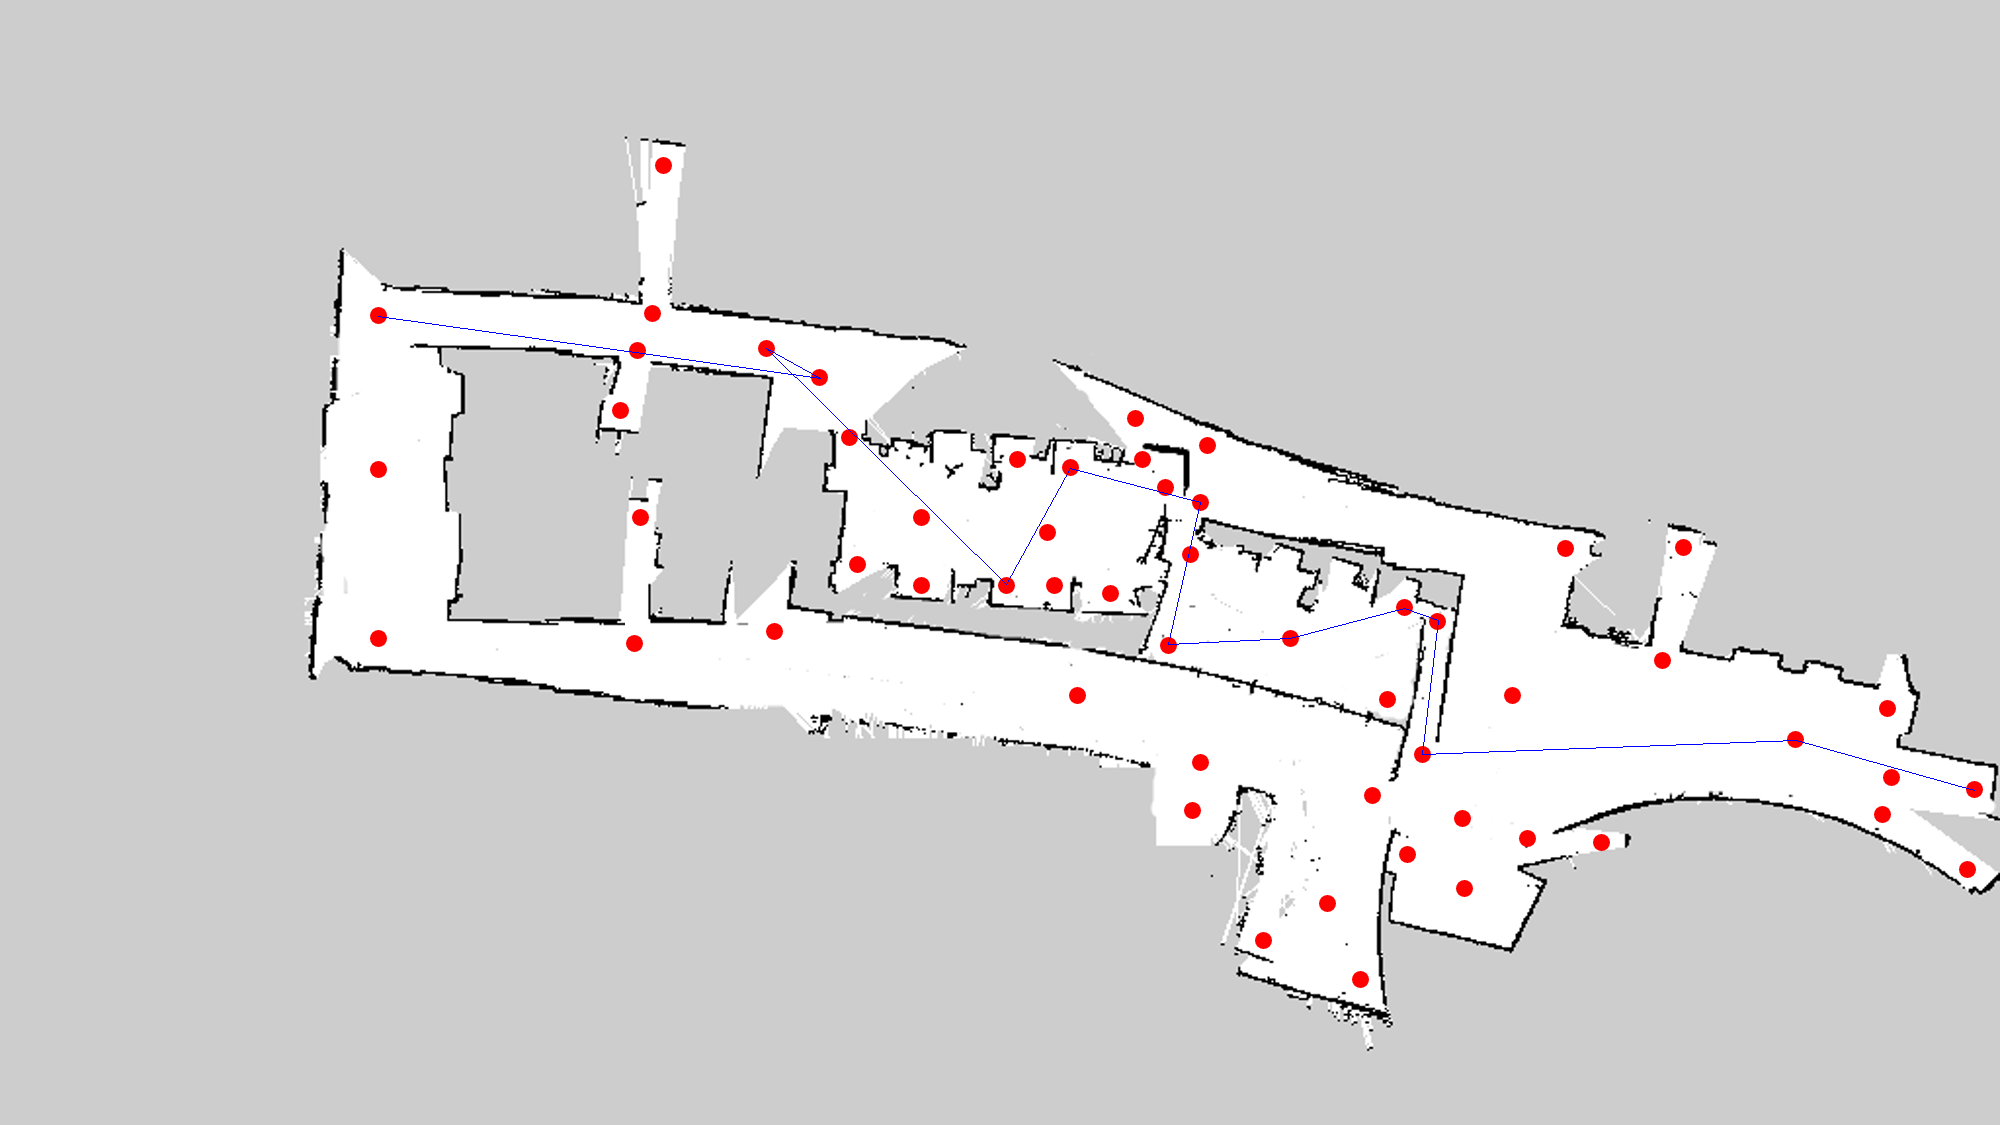

In [ ]:
def draw_node(nodeNumber, node_color):
  circle_position = (G.nodes[nodeNumber]['x'],G.nodes[nodeNumber]['y']) # i think cv2 already does the conversion (x,y) -> (y,x)
  radius = 20
  color = node_color
  thickness = 5
  global new_image # new_image is global and it is changed, so this statement allows the change. stackoverflow also mentioned "nonlocal"
  new_image = cv2.circle(new_image, circle_position, radius, color, thickness)
source_node = 0
dest_node = 54
index_to_get_actual_path = 1
img_to_draw = bold_nodes.copy()

# draw_node(0,(255,0,0))
# draw_node(1,(0,255,0))
# draw_node(2,(0,0,255))
# draw_node(54,(120,120,0))
# cv2_imshow(new_image) # 0 is blue, 1 is green, 2 is red


paths = dict(nx.all_pairs_dijkstra(G))
path_indexes = paths[source_node][index_to_get_actual_path][dest_node]
j = 0
while (j < len(path_indexes) - 1):
  u = path_indexes[j]
  v = path_indexes[j+1]
  u_x = G.nodes[u]['x']
  u_y = G.nodes[u]['y']
  v_x = G.nodes[v]['x']
  v_y = G.nodes[v]['y']
  cv2.line(img_to_draw,(u_x,u_y),(v_x,v_y),(255,0,0),thickness = 1)
  j  = j + 1
print(paths[source_node][index_to_get_actual_path][dest_node])
cv2_imshow(img_to_draw)